## Transfer Learning Design Pattern

In Transfer Learning, we take part of a previously trained model, freeze the weights, and incorporate these non-trainable layers into a new model that solves a similar problem, but on a smaller dataset. 

In [0]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import Sequential

### Building a medical imaging classification model with Keras and VGG

We'll use a [colorectal histology](https://www.tensorflow.org/datasets/catalog/colorectal_histology) dataset that comes pre-installed with TF Datasets. First we'll extract the data as a TF Dataset. Then we'll load a VGG model without the top classification layers. Finally, we'll add layers specific to our classification problem so that the final model outputs a softmax classification corresponding with 1 of the 8 classes in our dataset.

In [0]:
# These images will be (150,150,3)
(train, validation, test), info = tfds.load(
    'colorectal_histology',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'], 
    shuffle_files=True, 
    as_supervised=True,
    with_info=True
)

In [53]:
# Some info on the original dataset
info

tfds.core.DatasetInfo(
    name='colorectal_histology',
    version=2.0.0,
    description='Classification of textures in colorectal cancer histology. Each example is a 150 x 150 x 3 RGB image of one of 8 classes.',
    homepage='https://zenodo.org/record/53169#.XGZemKwzbmG',
    features=FeaturesDict({
        'filename': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(150, 150, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=8),
    }),
    total_num_examples=5000,
    splits={
        'train': 5000,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{kather2016multi,
      title={Multi-class texture analysis in colorectal cancer histology},
      author={Kather, Jakob Nikolas and Weis, Cleo-Aron and Bianconi, Francesco and Melchers, Susanne M and Schad, Lothar R and Gaiser, Timo and Marx, Alexander and Z{"o}llner, Frank Gerrit},
      journal={Scientific reports},
      volume={6},
      pages={27988},
      y

In [0]:
# Utility for what each label corresponds with
label_map = ['tumor','stroma','complex','lympho','debris','mucosa', 'adipose']

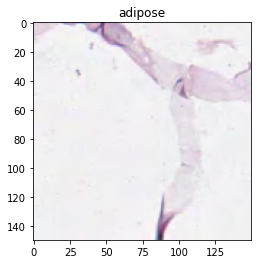

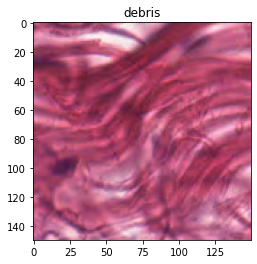

In [56]:
# Preview 2 examples from our dataset
get_label_name = info.features['label'].int2str
for image, label in train.take(2):
  plt.figure()
  plt.imshow(np.array(image))
  plt.title(get_label_name(label))

The labels in the original dataset are single scalar values (ranging from 0 to 7). We need to convert these to softmax arrays to train our model.

In [0]:
def label_format(image, label):
  return (image, tf.one_hot(label, depth=8))

train = train.map(label_format)
validation = validation.map(label_format)
test = test.map(label_format)

In [0]:
# Create batches
train_batch = train.shuffle(500).batch(32)
val_batch = validation.batch(32)
test_batch = test.batch(32)

In [71]:
for image_batch, label_batch in train_batch.take(1):
   pass

image_batch.shape

TensorShape([32, 150, 150, 3])

In [0]:
# Load the VGG model and set trainable to false
vgg_model = tf.keras.applications.VGG19(
    include_top=False, 
    weights='imagenet', 
    input_shape=((150,150,3)), 
    classifier_activation='softmax'
)

In [0]:
vgg_model.trainable = False

In [74]:
vgg_model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [0]:
feature_batch = vgg_model(image_batch)

In [76]:
global_avg_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_avg = global_avg_layer(feature_batch)
print(feature_batch_avg.shape)

(32, 512)


In [77]:
prediction_layer = tf.keras.layers.Dense(8, activation='softmax')
prediction_batch = prediction_layer(feature_batch_avg)
print(prediction_batch.shape)

(32, 8)


In [0]:
# Build our new model, implementing transfer learning
colorectal_model = keras.Sequential([
  vgg_model,
  global_avg_layer,
  prediction_layer
])

In [79]:
colorectal_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 4, 4, 512)         20024384  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 4104      
Total params: 20,028,488
Trainable params: 4,104
Non-trainable params: 20,024,384
_________________________________________________________________


In [0]:
colorectal_model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [81]:
colorectal_model.fit(
    train_batch,
    validation_data=val_batch,
    epochs=15
)

Epoch 1/15
125/125 [==============================] - 14s 109ms/step - loss: 1.8300 - accuracy: 0.4392 - val_loss: 1.7325 - val_accuracy: 0.5360
Epoch 2/15
125/125 [==============================] - 14s 109ms/step - loss: 1.6779 - accuracy: 0.5955 - val_loss: 1.6425 - val_accuracy: 0.6260
Epoch 3/15
125/125 [==============================] - 14s 110ms/step - loss: 1.6087 - accuracy: 0.6653 - val_loss: 1.5841 - val_accuracy: 0.6960
Epoch 4/15
125/125 [==============================] - 14s 110ms/step - loss: 1.5628 - accuracy: 0.7138 - val_loss: 1.5512 - val_accuracy: 0.7240
Epoch 5/15
125/125 [==============================] - 14s 111ms/step - loss: 1.5414 - accuracy: 0.7343 - val_loss: 1.5336 - val_accuracy: 0.7400
Epoch 6/15
125/125 [==============================] - 14s 111ms/step - loss: 1.5256 - accuracy: 0.7527 - val_loss: 1.5252 - val_accuracy: 0.7480
Epoch 7/15
125/125 [==============================] - 14s 112ms/step - loss: 1.5163 - accuracy: 0.7605 - val_loss: 1.5237 - val_ac

### Building a text classification model with TF Hub

We'll use the [IMDB movie review dataset](https://www.tensorflow.org/datasets/catalog/imdb_reviews) from TF Datasets. This contains 50k movie reviews with polarized sentiment. The goal is to train a model to predict whether a review is positive or negative. We'll use TF Hub to build the first layer of our model.

In [0]:
# Get the data and split into train, test, validate
reviews_train, reviews_validate, reviews_test = tfds.load(
    'imdb_reviews', 
    split=('train[:80%]', 'train[80%:90%]', 'test'),
    as_supervised=True
)

Since this is already formatted as a `tf.Data.dataset`, we'll preview it by iterating over the first five examples. You should see the review and its corresponding rating. 0 is negative, 1 is positive. When we built our model, we'll use sigmoid as the output since this is a binary classification task.

In [38]:
for i in reviews_train.take(5):
  print('Review text', i[0].numpy())
  print('Review sentiment', i[1].numpy(), '\n')

Review text b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
Review sentiment 0 

Review text b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because t

Here we'll import a TF Hub module for text classification. Because we're using TF Hub, we can feed the data to our model directly as strings. We don't need to worry about preprocessing since TF Hub will handle converting the text to embeddings for us.

In [0]:
hub_layer = hub.KerasLayer("https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1",
                           input_shape=[], dtype=tf.string, trainable=True)

To see what the TF Hub layer is doing, let's see the embedding for an example sentence.

In [57]:
test_embedding = hub_layer(["I'm excited to try out transfer learning with TF Hub"])
print(test_embedding)

tf.Tensor(
[[ 0.3780208  -0.8602792   0.47116035  0.87798494 -1.6212037  -0.93068135
  -0.15095684  0.24388756 -0.6550514   0.12114644 -1.3243198   0.73917985
   0.52290976  0.6004198  -1.0018169   0.27700785  1.8433737   0.11805207
  -0.1830085  -0.6638955 ]], shape=(1, 20), dtype=float32)


In [58]:
model = keras.Sequential([
  hub_layer,
  keras.layers.Dense(32, activation='relu'),
  keras.layers.Dense(1, activation='sigmoid')                          
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_2 (KerasLayer)   (None, 20)                400020    
_________________________________________________________________
dense_4 (Dense)              (None, 32)                672       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 400,725
Trainable params: 400,725
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [60]:
# Note: you can train for more epochs to get higher accuracy
model.fit(
    reviews_train.shuffle(10000).batch(512), 
    validation_data=reviews_validate.batch(512), 
    epochs=15
)

Epoch 1/15
40/40 [==============================] - 4s 91ms/step - loss: 0.6748 - accuracy: 0.5717 - val_loss: 0.6563 - val_accuracy: 0.6228
Epoch 2/15
40/40 [==============================] - 3s 81ms/step - loss: 0.6539 - accuracy: 0.6571 - val_loss: 0.6410 - val_accuracy: 0.6684
Epoch 3/15
40/40 [==============================] - 4s 95ms/step - loss: 0.6380 - accuracy: 0.7063 - val_loss: 0.6244 - val_accuracy: 0.7284
Epoch 4/15
40/40 [==============================] - 4s 89ms/step - loss: 0.6209 - accuracy: 0.7558 - val_loss: 0.6104 - val_accuracy: 0.7648
Epoch 5/15
40/40 [==============================] - 4s 90ms/step - loss: 0.6063 - accuracy: 0.7919 - val_loss: 0.5997 - val_accuracy: 0.8040
Epoch 6/15
40/40 [==============================] - 4s 89ms/step - loss: 0.5946 - accuracy: 0.8185 - val_loss: 0.5903 - val_accuracy: 0.8120
Epoch 7/15
40/40 [==============================] - 4s 88ms/step - loss: 0.5841 - accuracy: 0.8413 - val_loss: 0.5834 - val_accuracy: 0.8332
Epoch 8/15
40

In [61]:
# Evaluate the model
results = model.evaluate(reviews_test.batch(512))

49/49 [==============================] - 4s 77ms/step - loss: 0.5705 - accuracy: 0.8641


Here we'll generate predictions on example from our test dataset, and print out the first 10 predictions along with their corresponding review text. 

The output of our model is a value between 0 and 1. Values close to 0 indicate a confident negative review, and values close to 1 indicate a confident positive review.

In [0]:
prediction = model.predict(reviews_test.batch(512))

In [55]:
for i,val in enumerate(reviews_test.take(10)):
  print(val[0])
  print(prediction[i][0])
  print()

tf.Tensor(b"There are films that make careers. For George Romero, it was NIGHT OF THE LIVING DEAD; for Kevin Smith, CLERKS; for Robert Rodriguez, EL MARIACHI. Add to that list Onur Tukel's absolutely amazing DING-A-LING-LESS. Flawless film-making, and as assured and as professional as any of the aforementioned movies. I haven't laughed this hard since I saw THE FULL MONTY. (And, even then, I don't think I laughed quite this hard... So to speak.) Tukel's talent is considerable: DING-A-LING-LESS is so chock full of double entendres that one would have to sit down with a copy of this script and do a line-by-line examination of it to fully appreciate the, uh, breadth and width of it. Every shot is beautifully composed (a clear sign of a sure-handed director), and the performances all around are solid (there's none of the over-the-top scenery chewing one might've expected from a film like this). DING-A-LING-LESS is a film whose time has come.", shape=(), dtype=string)
0.43071708

tf.Tensor(


Copyright 2020 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License